## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [17]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [18]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2

Now let's explore some of the data, for starters we will use the following Kaggle dataset: [lego-brick-images](https://www.kaggle.com/joosthazelzet/lego-brick-images)

It's a fairly simple dataset containing renders of some LEGO pieces

In [19]:
os.listdir("../../LEGO_brick_images_v1")

['11214 Bush 3M friction with Cross axle',
 '18651 Cross Axle 2M with Snap friction',
 '2357 Brick corner 1x2x2',
 '3003 Brick 2x2',
 '3004 Brick 1x2',
 '3005 Brick 1x1',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 Plate 1x1',
 '3040 Roof Tile 1x2x45deg',
 '3069 Flat Tile 1x2',
 '32123 half Bush',
 '3673 Peg 2M',
 '3713 Bush for Cross Axle',
 '3794 Plate 1X2 with 1 Knob',
 '6632 Technic Lever 3M']

The first numbers denote the brick model, after that is it's name, size and possible modifications

In [20]:
os.listdir("../../LEGO_brick_images_v1/3003 Brick 2x2/")[:10]

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png']

We can see that the folder are filled with individual .png files, these are loadable in Keras.

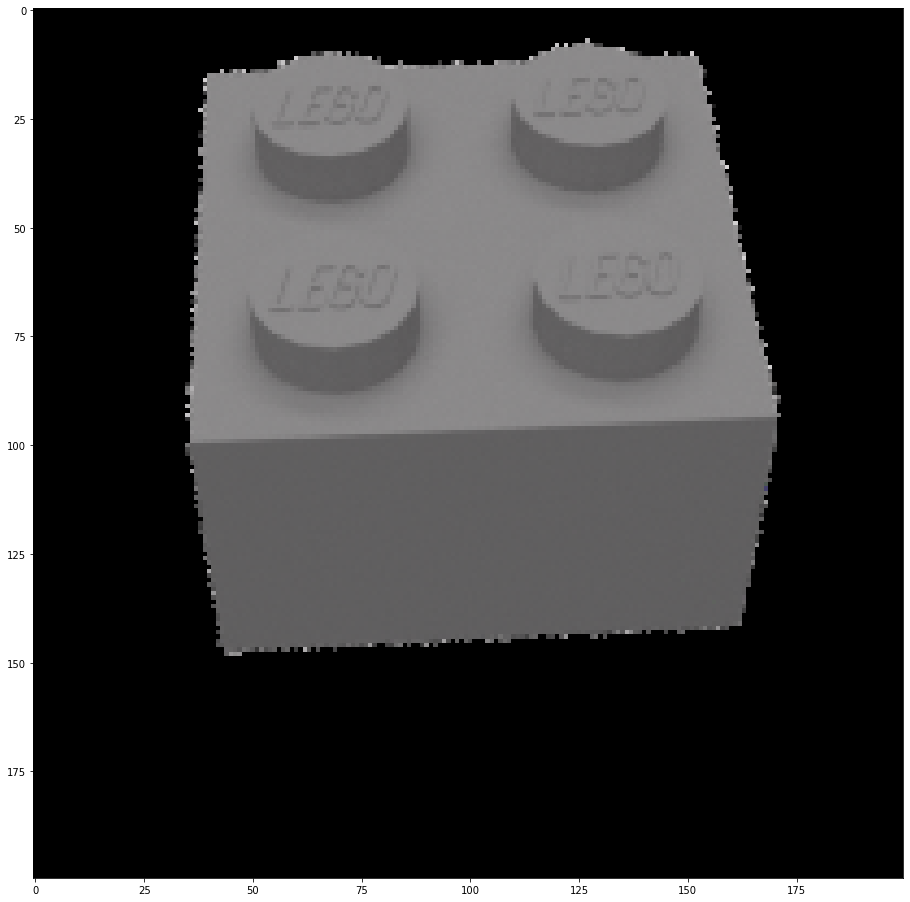

In [21]:
image_path = "../../LEGO_brick_images_v1/3003 Brick 2x2/0002.png"
image = cv2.imread(image_path)
plt.figure(figsize=(16,16))
plt.imshow(image)

In [22]:
image.shape

(200, 200, 3)

To try to load the data into Keras, we must first create a subset for training and validation

In [23]:
dataset_path = "../../LEGO_brick_images_v1/"
dataset_output = "./output"

In [24]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [25]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=[0.5,1]
)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), target_size=(200,200), shuffle=True, class_mode='categorical')


print(len(train_generator.class_indices))

Found 4465 images belonging to 16 classes.
Found 1914 images belonging to 16 classes.
16


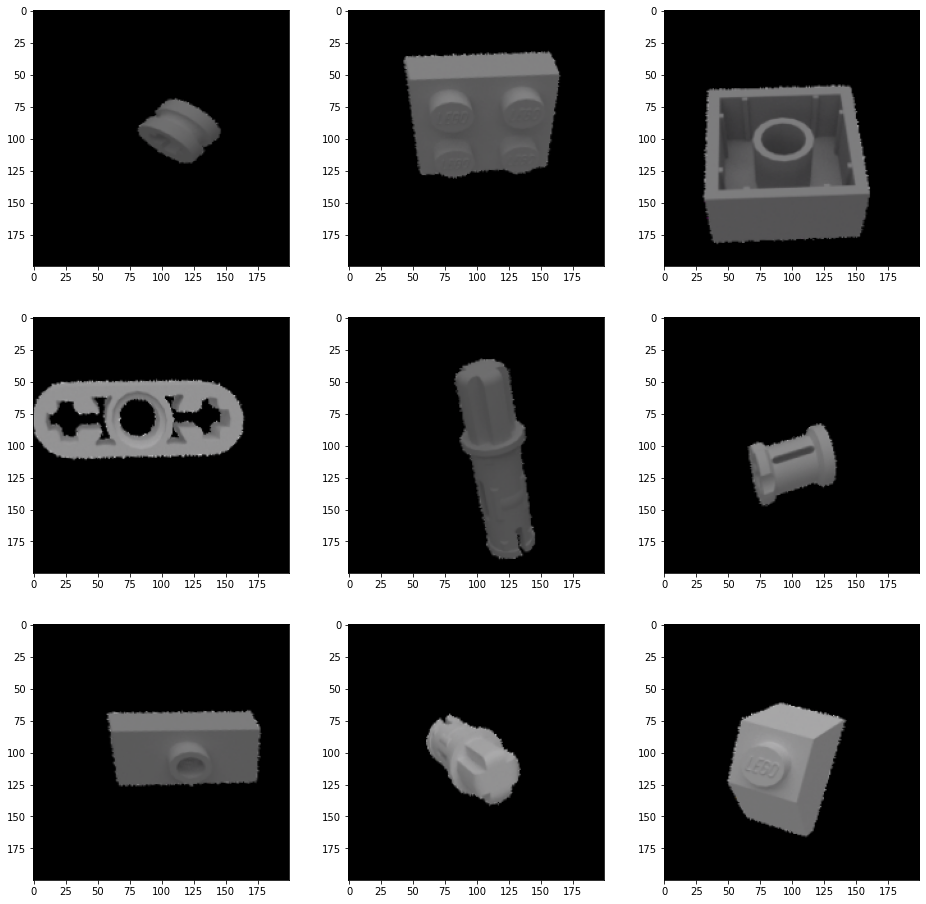

In [26]:
plt.figure(figsize=(16,16))
for i in range(9):
    plt.subplot(330+1+i)
    batch = train_generator.next()[0]
    plt.imshow(batch[0])
plt.show()


Now to declare a model and modify it, we can also use preexisting ones like VGG16 or ResNet but for this test we are using a simple one

In [27]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, Model

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(200,200,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                20072512  
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
Total params: 20,074,448
Trainable params: 20,074,448
Non-trainable params: 0
________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model.png", show_shapes = True)

In [28]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce,earlystop]

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [29]:
from keras.optimizers import SGD

opt = SGD(lr=1e-2) #dobar za plitke mreže
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = None, 
    validation_data  = validation_generator,
    validation_steps = None,
    epochs = 100, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/100
140/140 [==============================] - 112s 801ms/step - loss: 2.5618 - acc: 0.1473 - val_loss: 2.1959 - val_acc: 0.2440

Epoch 00001: val_loss improved from inf to 2.19589, saving model to ./base.model
Epoch 2/100
140/140 [==============================] - 64s 454ms/step - loss: 2.3701 - acc: 0.2109 - val_loss: 2.0001 - val_acc: 0.2780

Epoch 00002: val_loss improved from 2.19589 to 2.00011, saving model to ./base.model
Epoch 3/100
140/140 [==============================] - 64s 458ms/step - loss: 2.2437 - acc: 0.2412 - val_loss: 1.8707 - val_acc: 0.3459

Epoch 00003: val_loss improved from 2.00011 to 1.87073, saving model to ./base.model
Epoch 4/100
140/140 [==============================] - 64s 456ms/step - loss: 2.1643 - acc: 0.2496 - val_loss: 1.7434 - val_acc: 0.3945

Epoch 00004: val_loss improved from 1.87073 to 1.74336, saving model to ./base.model
Epoch 5/100
140/140 [==============================] - 63s 453ms/step - loss: 2.1044 - acc: 0.2719 - val_loss: 1.65

In [30]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

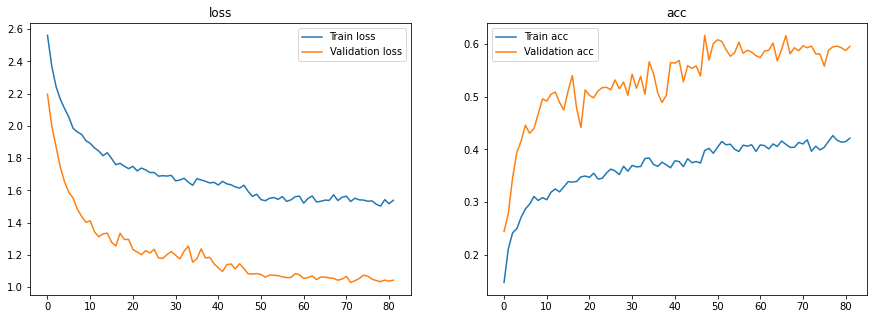

In [31]:
show_final_history(history)

In [32]:
#image_path = "../../LEGO_brick_images_v1/2357 Brick corner 1x2x2/201706171206-0001.png"
image_path = "../../LEGO_brick_images_v1/3004 Brick 1x2/0003.png"
image = cv2.imread(image_path)

from numpy import array
json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = np.expand_dims(image, axis=0)
prediction = loaded_model.predict_classes(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                20072512  
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
Total params: 20,074,448
Trainable params: 20,074,448
Non-trainable params: 0
________________________________________________________________